# Audio classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path 
from fastai.vision import *
from fastai.metrics import error_rate
import pandas as pd

In [3]:
bs = 32

In [4]:
path = %pwd
path = Path(f'{path}/../data/')

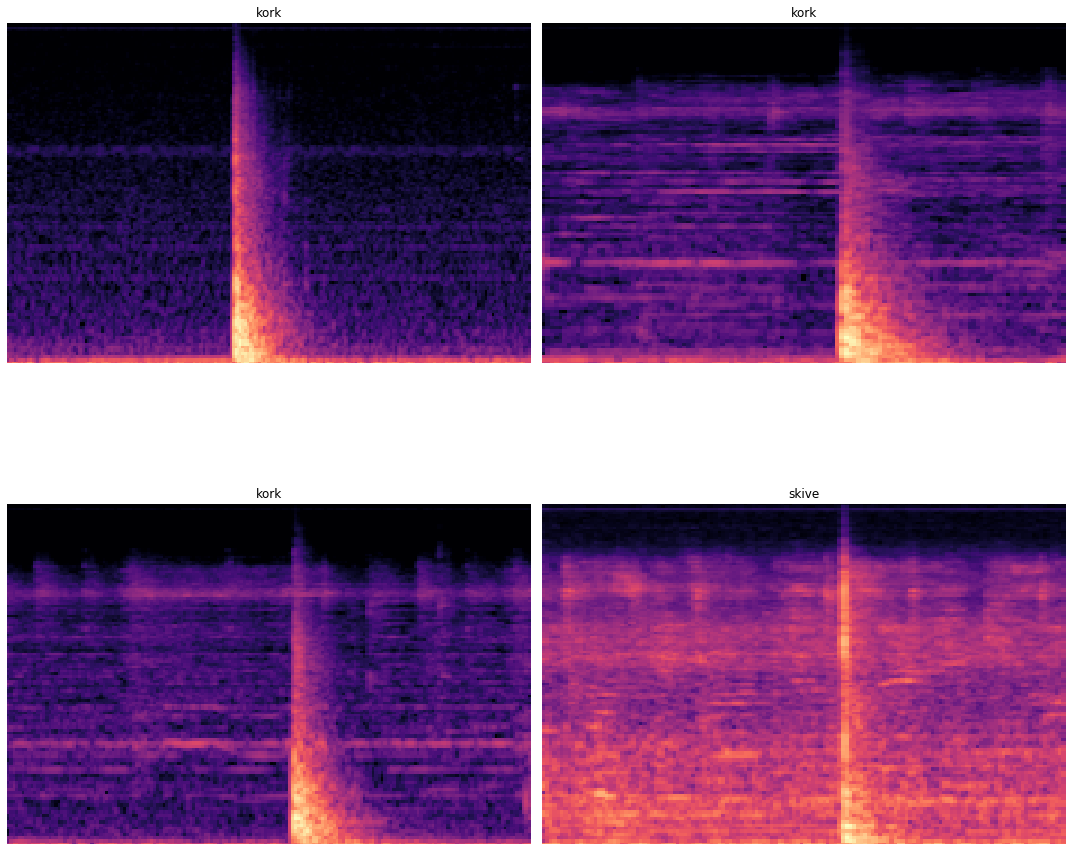

In [5]:
data = ImageDataBunch.from_folder(path, train="train_melspecs", valid='val_melspecs', ds_tfms=None, bs=bs)
data.normalize(imagenet_stats)
data.show_batch(rows=2, figsize=(15,15))

In [6]:
data

ImageDataBunch;

Train: LabelList (69 items)
x: ImageList
Image (3, 302, 465),Image (3, 302, 465),Image (3, 302, 465),Image (3, 302, 465),Image (3, 302, 465)
y: CategoryList
blink,blink,blink,blink,blink
Path: /home/sathiesh/ml/audio_classification/nbs/../data;

Valid: LabelList (21 items)
x: ImageList
Image (3, 302, 465),Image (3, 302, 465),Image (3, 302, 465),Image (3, 302, 465),Image (3, 302, 465)
y: CategoryList
blink,blink,blink,blink,blink
Path: /home/sathiesh/ml/audio_classification/nbs/../data;

Test: None

In [7]:
print(data.classes) 

['blink', 'kork', 'skive']


## Training

In [27]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy, ps =0.6)

In [16]:
#learn.summary()

In [17]:
#learn.unfreeze()
#learn.summary()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-04
Min loss divided by 10: 1.74E-02


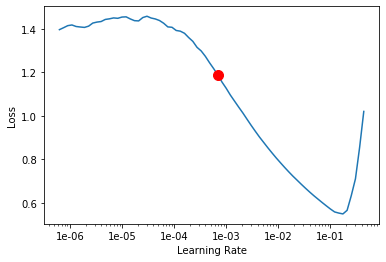

In [11]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [13]:
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

0.0006918309709189362

In [28]:
lr= 1e-3
learn.fit_one_cycle(25, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.830288,1.588904,0.333333,00:01
1,1.681260,1.264699,0.333333,00:01
2,1.662534,1.069494,0.333333,00:01
3,1.521432,0.961653,0.571429,00:01
4,1.365341,0.855347,0.714286,00:01
5,1.219190,0.717685,0.809524,00:01
6,1.089199,0.593325,0.809524,00:01
7,0.973526,0.492381,0.761905,00:01
8,0.881194,0.407101,0.904762,00:01
9,0.799553,0.348430,0.904762,00:01


In [29]:
learn.save('final_model')

## Interpretation

In [36]:
import fastai.vision as fvision

In [37]:
# class DatasetFormatter():
#     "Returns a dataset with the appropriate format and file indices to be displayed."
#     @classmethod
#     def from_toplosses(cls, learn, n_imgs=None, **kwargs):
#         "Gets indices with top losses."
#         train_ds, train_idxs = cls.get_toplosses_idxs(learn, n_imgs, **kwargs)
#         return train_ds, train_idxs

#     @classmethod
#     def get_toplosses_idxs(cls, learn, n_imgs, **kwargs):
#         "Sorts `ds_type` dataset by top losses and returns dataset and sorted indices."
#         dl = learn.data.fix_dl
#         if not n_imgs: n_imgs = len(dl.dataset)
#         _,_,top_losses = learn.get_preds(ds_type=DatasetType.Fix, with_loss=True)
#         idxs = torch.topk(top_losses, n_imgs)[1]
#         return cls.padded_ds(dl.dataset, **kwargs), idxs

In [39]:
learn.load('final_model');

In [40]:
from fastai.vision import *

In [41]:
# ds, idxs = DatasetFormatter().from_toplosses(learn)

In [42]:
preds,y,losses = learn.get_preds(with_loss=True,ds_type=fvision.DatasetType.Train)

In [43]:
preds.shape

torch.Size([64, 3])

In [44]:
interp = ClassificationInterpretation.from_learner(learn,ds_type=fvision.DatasetType.Train)

In [45]:
interp.preds.shape

torch.Size([64, 3])

In [46]:
y_true = np.array(interp.y_true).ravel()
y_preds = np.array(interp.preds).ravel()

In [47]:
y_preds.shape

(192,)

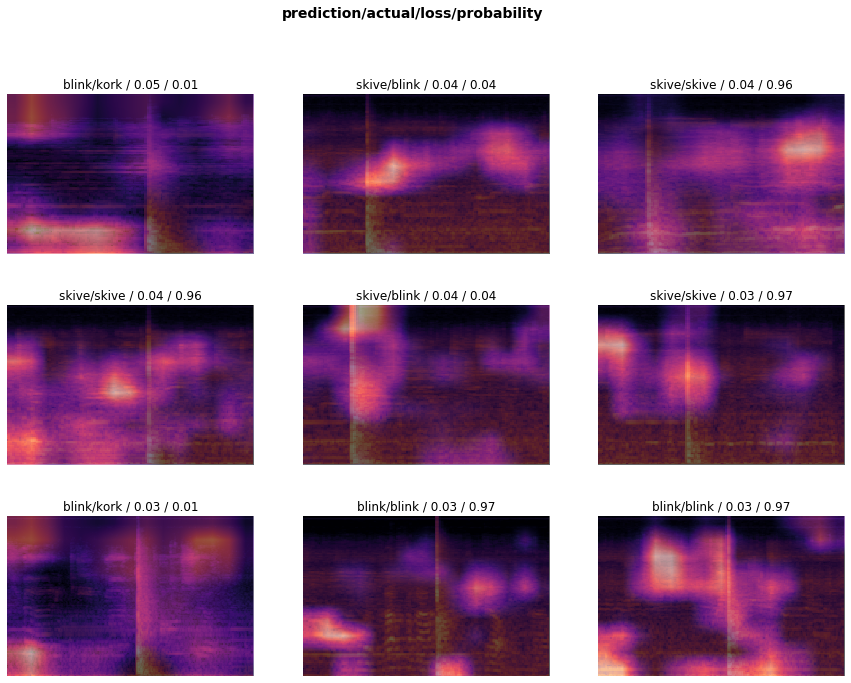

In [48]:
interp.plot_top_losses(9, figsize=(15,11))

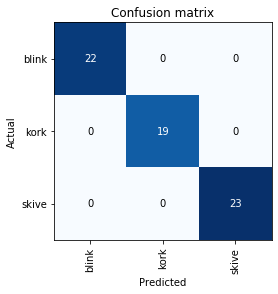

In [49]:
interp.plot_confusion_matrix()

#### Heatmap


Category skive

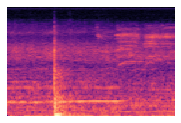

In [99]:
idx=10
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [116]:
m = learn.model.eval();
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [139]:
from fastai.callbacks.hooks import *

In [157]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            print(int(cat))
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [158]:
hook_a,hook_g = hooked_backward()

2


In [159]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 10, 15])

In [160]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([10, 15])

In [175]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

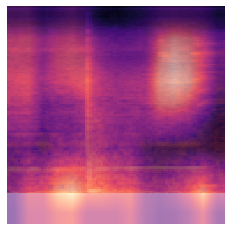

In [176]:
show_heatmap(avg_acts)

# Production model

In [51]:
learn.export()